<a href="https://colab.research.google.com/github/Anderson-Lee-Git/cse447-nlp/blob/main/src/sample_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch transformers datasets tqdm gdown==v4.6.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


# Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("openbookqa")
dataset_train, dataset_valid, dataset_test = dataset["train"], dataset["validation"], dataset["test"]
print(dataset_train)
print(dataset_valid)
print(f"first question sample: {dataset_train['question_stem'][0]}")
# Note that choices contains 'text' and 'label' keys
print(f"first choice sample: {dataset_train['choices'][0]}")
print(f"first answer key sample: {dataset_train['answerKey'][0]}")
# make sure every label ordering in choices is in order ['A', 'B', 'C', 'D']
for choice in dataset_train["choices"]:
    assert choice["label"] == ['A', 'B', 'C', 'D']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 4957
})
Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 500
})
first question sample: The sun is responsible for
first choice sample: {'text': ['puppies learning new tricks', 'children growing up and getting old', 'flowers wilting in a vase', 'plants sprouting, blooming and wilting'], 'label': ['A', 'B', 'C', 'D']}
first answer key sample: D


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizerFast
from datasets import load_dataset
from dataclasses import dataclass

@dataclass
class OpenQASample:
    id: str
    question_stem: str
    choices: list[str]
    labels: list[str]
    answer_key: str

    @staticmethod
    def from_dict(data: dict):
        return OpenQASample(
            id=data["id"],
            question_stem=data["question_stem"],
            choices=data["choices"],
            labels=data["labels"],
            answer_key=data["answer_key"]
        )

class OpenQADataset(Dataset):
    tokenizer: PreTrainedTokenizerFast = None

    def __init__(self, split):
        self.data = [
            OpenQASample(**{
                "id": raw_sample["id"],
                "question_stem": raw_sample["question_stem"],
                "choices": raw_sample["choices"]["text"],
                "labels": raw_sample["choices"]["label"],
                "answer_key": raw_sample["answerKey"]
            }) for raw_sample in OpenQADataset.get_openqa(split)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def get_openqa(split):
        dataset = load_dataset("openbookqa")
        return dataset[split]

    @staticmethod
    def format_question(question):
        return question

    @staticmethod
    def format_choices(choices, labels):
        for i in range(len(choices)):
            choices[i] = f"{labels[i]} - {choices[i]}"
        return choices

    @staticmethod
    def format_answer_keys(answer_keys):
        """
        Format answer keys from A, B, C, D to 0, 1, 2, 3
        :param: list of answer keys in integer
        """
        return [ord(a) - ord("A") for a in answer_keys]

    @staticmethod
    def collate_fn(batched_samples):
        B = len(batched_samples)
        batched_question = [[OpenQADataset.format_question(sample.question_stem)] * 4 for sample in batched_samples]  # B, 4
        batched_choices = [OpenQADataset.format_choices(sample.choices, sample.labels) for sample in batched_samples]  # B, 4
        batched_answer_key = [sample.answer_key for sample in batched_samples]  # B, 1
        # flatten batched_questions for tokenization
        batched_question = sum(batched_question, [])
        batched_choices = sum(batched_choices, [])
        # Tokenize the input texts.
        text_encoding = OpenQADataset.tokenizer(batched_question,
                                                batched_choices,
                                                padding=True,
                                                max_length=128,
                                                truncation=True,
                                                return_tensors="pt")
        # unflatten
        label_encoding = torch.LongTensor(OpenQADataset.format_answer_keys(batched_answer_key))  # B, 1

        return {
            "text_encoding": {k: v.view(B, 4, -1) for (k, v) in text_encoding.items()},
            "label_encoding": label_encoding,
        }

# Evaluation

In [ ]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

def compute_accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    accuracy = torch.sum(predictions == labels) / len(predictions)
    return accuracy

@torch.no_grad
def evaluate(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    for batch in tqdm(dataloader):
        text_encoding = batch["text_encoding"]
        for k, v in text_encoding.items():
            text_encoding[k] = v.to(model.device)
        label_encoding = batch["label_encoding"].to(model.device)
        out = model(**text_encoding, labels=label_encoding)
        logits = out.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions += predictions
        all_labels += label_encoding
    all_predictions = torch.Tensor(all_predictions)
    all_labels = torch.Tensor(all_labels)
    accuracy = compute_accuracy(all_predictions, all_labels)
    print(accuracy)

# device = "cuda"
# model = AutoModelForMultipleChoice.from_pretrained("nghuyong/ernie-1.0-base-zh").to(device)
# tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-1.0-base-zh")
# OpenQADataset.tokenizer = tokenizer
# dataset_train = OpenQADataset("train")
# dataloader_train = DataLoader(dataset=dataset_train,
#                             batch_size=128,
#                             collate_fn=OpenQADataset.collate_fn)
# print(model.num_parameters())
# evaluate(model, dataloader_train)

In [ ]:

# prompt = Question: the question, Options: concatenated list of answers
# ### do input stuff
# answer = model(**inputs)

# if answer is in options:
#   final_answre = answer
# else:
#   final_answer = sbert.multiple_choice(answer, choices)

prompt = Question: the question, Option 1:


for each question:
  option1, option2, option3, option4 = options broken up
  prompt1,2,3 = Question + option1,option2...

  probs = [len 4]
  ouput = model(promptx)
  softmax(output.logits())

  get prob for sequence being generated (sequence = optionx)
  prob[x] = prob

chosen = argmax(prob)
final = options[chosen]
loss += beta*cossim(final, correct)

loss.backward()
optimizer.step()
optimizer.zero_grad()


SyntaxError: invalid syntax (<ipython-input-17-f0892ea7ca47>, line 10)

In [ ]:
! pip install datasets
import torch
import random
from tqdm import tqdm
import torch.nn.functional as F
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from transformers import AdamW, set_seed
from typing import Dict, Union, List, Tuple

In [ ]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice, AutoModelForCausalLM, RobertaTokenizer, RobertaModel, LlamaForCausalLM, LlamaTokenizer

# model1 = AutoModelForCausalLM.from_pretrained("WizardLM/WizardLM-13B-V1.2").to(device)
# tokenizer1 = AutoTokenizer.from_pretrained("WizardLM/WizardLM-13B-V1.2")

# model2 = LlamaForCausalLM.from_pretrained("/output/path")
# tokenizer2 = LlamaTokenizer.from_pretrained("/output/path")

# tokenizer3 = RobertaTokenizer.from_pretrained('roberta-base')
model3 = AutoModelForCausalLM.from_pretrained('roberta-base').cuda()

tokenizer3 = AutoTokenizer.from_pretrained('roberta-base', padding_side = 'left')
tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3.config.pad_token_id = tokenizer3.eos_token_id

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
print(dataset_train)
print(dataset_valid)
print(f"first question sample: {dataset_train['question_stem'][0]}")
# Note that choices contains 'text' and 'label' keys
print(f"first choice sample: {dataset_train['choices'][0]}")
print(f"first answer key sample: {dataset_train['answerKey'][0]}")

Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 4957
})
Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 500
})
first question sample: The sun is responsible for
first choice sample: {'text': ['puppies learning new tricks', 'children growing up and getting old', 'flowers wilting in a vase', 'plants sprouting, blooming and wilting'], 'label': ['A', 'B', 'C', 'D']}
first answer key sample: D


PROCESS ROWS OF DATASET TRIAN

In [ ]:
concat_prompts_train = []
concat_prompts_valid = []

for row in dataset_train:
  char_count = ord(row['answerKey']) - ord('A')
  # print(char_count)
  answer = row['choices']['text'][char_count]
  question = row['question_stem']
  concat = [row['id'], question]
  for option in row['choices']['text']:
    concat.append(question + ' ' + option)
  concat.append(char_count)
  # break
  concat_prompts_train.append(concat)
  # print(row)
  # break

for row in dataset_valid:
  char_count = ord(row['answerKey']) - ord('A')
  # print(char_count)
  char_count = ord(row['answerKey']) - ord('A')
  # print(char_count)
  answer = row['choices']['text'][char_count]
  question = row['question_stem']
  concat = [row['id'], question]
  for option in row['choices']['text']:
    concat.append(question + ' ' + option)
  concat.append(char_count)
  # break
  concat_prompts_valid.append(concat)

print([row[-1] for row in concat_prompts_train[:10]])
# print(concat_prompts_valid[:10])

[3, 3, 2, 2, 3, 0, 3, 3, 0, 3]


In [ ]:
test_train = concat_prompts_train[:5]

In [ ]:
prompts_train = []
prompts_valid = []

for row in concat_prompts_train:
  prompt = row[2:6]
  prompts_train.append(prompt)

for row in concat_prompts_valid:
  prompt = row[2:6]
  prompts_valid.append(prompt)

# print(prompts_train)

In [ ]:
batch = prompts_train[0]
print(batch)

['The sun is responsible for puppies learning new tricks', 'The sun is responsible for children growing up and getting old', 'The sun is responsible for flowers wilting in a vase', 'The sun is responsible for plants sprouting, blooming and wilting']


In [ ]:
input_tokens = tokenizer3(batch, truncation=True, padding=True, return_tensors='pt').to('cuda')
# print(input_tokens)
output = model3(**input_tokens)
print(output.logits.shape)

NameError: name 'batch' is not defined

In [ ]:

for prompt in prompts_train:
  batch = prompt
  input_tokens = tokenizer3(batch, truncation=True, padding=True, return_tensors='pt').to('cuda')

  # print(input_tokens)
  output = model3(**input_tokens)
  log_probs = F.log_softmax(output.logits, dim=-1)
  # print(input_tokens['input_ids'].shape)
  # print(input_tokens['input_ids'])
  output_tokens = input_tokens['input_ids'][:, 1:]
  # print(output_tokens.shape)
  # print(log_probs.shape)

  chosen_log_probs = log_probs[:, :-1, :]
  # print(output_tokens.shape)
  # print(chosen_log_probs.shape)
  chosen_log_probs = torch.gather(chosen_log_probs, 2, output_tokens.unsqueeze(-1))
  chosen_log_probs = chosen_log_probs.squeeze(-1)

  # print(chosen_log_probs)
  # print('size', chosen_log_probs.shape)
  # print(output.logits.shape)
  print(torch.argmax(F.softmax(torch.sum(chosen_log_probs, dim=1).detach())))
# [3, 3, 2, 2, 3, 0, 3, 3, 0, 3]

CROSS ENTROPY LOSS TO GET LOSS HEHE
TRAIN

SyntaxError: invalid syntax (<ipython-input-8-fce5ca11642a>, line 26)

In [ ]:
def preprocess(dataset):
  dataset = load_dataset(dataset)
  dataset_train, dataset_valid, dataset_test = dataset["train"], dataset["validation"], dataset["test"]

  concat_prompts_train = []
  concat_prompts_valid = []

  for row in dataset_train:
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    answer = row['choices']['text'][char_count]
    question = row['question_stem']
    concat = [row['id'], question]
    for option in row['choices']['text']:
      concat.append(question + ' ' + option)
    concat.append(char_count)
    # break
    concat_prompts_train.append(concat)
    # print(row)
    # break

  for row in dataset_valid:
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    answer = row['choices']['text'][char_count]
    question = row['question_stem']
    concat = [row['id'], question]
    for option in row['choices']['text']:
      concat.append(question + ' ' + option)
    concat.append(char_count)
    # break
    concat_prompts_valid.append(concat)


    prompts_train = []
    prompts_valid = []

    for row in concat_prompts_train:
      prompt = row[2:6]
      prompts_train.append(prompt)

    for row in concat_prompts_valid:
      prompt = row[2:6]
      prompts_valid.append(prompt)

    return concat_prompts_train, concat_prompts_valid, prompts_train, prompts_valid



In [ ]:
concat_prompts_train, concat_prompts_valid, prompts_train, prompts_valid = preprocess("openbookqa")
optimizer = AdamW(model3.parameters(), lr=1e-4)
print(concat_prompts_train[0])
concat_prompts_train = [sublist[-1] for sublist in concat_prompts_train]

['7-980', 'The sun is responsible for', 'The sun is responsible for puppies learning new tricks', 'The sun is responsible for children growing up and getting old', 'The sun is responsible for flowers wilting in a vase', 'The sun is responsible for plants sprouting, blooming and wilting', 3]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

def train(model, optimizer, tokenizer, lr=1e-4, batch_size=1):
  global prompts_train, prompts_valid, concat_prompts_train, concat_prompts_valid
  losses = []
  # init_loss = 0
  for epoch in range(3):
    for i, prompt in enumerate(prompts_train):
      batch = prompt
      input_tokens = tokenizer(batch, truncation=True, padding=True, return_tensors='pt').to('cuda')

      # print(input_tokens)
      output = model(**input_tokens)
      log_probs = F.log_softmax(output.logits, dim=-1)
      # print(input_tokens['input_ids'].shape)
      # print(input_tokens['input_ids'])
      output_tokens = input_tokens['input_ids'][:, 1:]
      # print(output_tokens.shape)
      # print(log_probs.shape)

      chosen_log_probs = log_probs[:, :-1, :]
      # print(output_tokens.shape)
      # print(chosen_log_probs.shape)
      chosen_log_probs = torch.gather(chosen_log_probs, 2, output_tokens.unsqueeze(-1))
      chosen_log_probs = chosen_log_probs.squeeze(-1)
      prob = F.softmax(torch.sum(chosen_log_probs, dim=1).detach(), dim=-1).to('cuda')
      # print(prob)
      # [ , , , ]

      target = concat_prompts_train[i][-1]
      # print('target', target, prob[target], torch.argmax(prob))

      # some loss here figure it out
      prob = prob.clone().detach().requires_grad_(True).to('cuda')

      loss = F.xt(prob, torch.tensor(target).to('cuda'))

      # if torch.argmax(F.softmax(torch.sum(chosen_log_probs, dim=1).detach(), dim=-1)) != target:
      #   print('incorrect loss', loss)
      # else:
      #   print('correct loss', loss)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      losses.append(loss.item())

  return losses

def train2(model, optimizer, tokenizer, lr=1e-4, batch_size=1, epochs=3):
  global prompts_train, prompts_valid, concat_prompts_train, concat_prompts_valid

  losses = []
  print(concat_prompts_train)

  total_correct = 0
  total = 0
  for epoch in range(epochs):
    for i in range(0, len(prompts_train), batch_size):
      batch_prompts = prompts_train[i:i+batch_size]
      flattened_batch_prompts = [item for sublist in batch_prompts for item in sublist]
      # print(flattened_batch_prompts)

      input_tokens = tokenizer(flattened_batch_prompts, truncation=True, padding=True, return_tensors='pt').to('cuda')

      # print(input_tokens)
      output = model(**input_tokens)
      log_probs = F.log_softmax(output.logits, dim=-1)
      # print(input_tokens['input_ids'].shape)
      # print(input_tokens['input_ids'])
      output_tokens = input_tokens['input_ids'][:, 1:]
      # print(output_tokens.shape)
      # print(log_probs.shape)

      chosen_log_probs = log_probs[:, :-1, :]
      # print(output_tokens.shape)
      # print(chosen_log_probs.shape)
      chosen_log_probs = torch.gather(chosen_log_probs, 2, output_tokens.unsqueeze(-1))
      chosen_log_probs = chosen_log_probs.squeeze(-1)
      prob = F.softmax(torch.mean(chosen_log_probs, dim=1).detach(), dim=-1).to('cuda')
      prob = (prob.view(len(batch_prompts), 4))


      target = concat_prompts_train[i:i+batch_size]
      target = torch.tensor(target).to('cuda')

      predictions = torch.argmax(prob, dim =1)
      matching_mask = target == predictions

      num_matches = torch.sum(matching_mask).item()
      total_correct += num_matches
      total += len(matching_mask)
      # print(num_matches)
      # print(total)
      prob = prob.clone().detach().requires_grad_(True).to('cuda')

      loss = F.cross_entropy(prob, target, reduction='mean')
      # print(loss)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      losses.append(loss.item())
  print(total_correct)
  print(total)

  return losses

In [ ]:
optimizer = AdamW(model3.parameters(), lr=1e-4)
# train ,_losses = train(model3, optimizer, tokenizer3)
train2(model3, optimizer, tokenizer3, batch_size = 16)
print(train_losses)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[3, 3, 2, 2, 3, 0, 3, 3, 0, 3, 0, 2, 1, 1, 1, 0, 3, 0, 2, 0, 1, 3, 0, 3, 3, 0, 3, 2, 1, 3, 0, 2, 2, 2, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 3, 2, 1, 1, 2, 0, 3, 0, 1, 1, 0, 0, 3, 0, 3, 0, 1, 1, 3, 2, 2, 3, 2, 0, 2, 3, 1, 3, 0, 3, 3, 0, 3, 0, 1, 0, 3, 3, 2, 0, 0, 1, 3, 1, 3, 2, 3, 0, 0, 0, 1, 3, 0, 0, 3, 1, 1, 0, 3, 3, 3, 0, 0, 2, 0, 0, 3, 1, 1, 0, 1, 0, 2, 0, 2, 2, 0, 1, 2, 1, 0, 3, 0, 2, 2, 1, 1, 3, 2, 2, 2, 2, 3, 0, 3, 0, 3, 0, 2, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 3, 1, 2, 0, 3, 0, 2, 2, 0, 2, 2, 2, 1, 0, 3, 1, 0, 1, 0, 1, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 3, 0, 1, 2, 1, 0, 3, 3, 3, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 2, 2, 1, 3, 2, 0, 3, 3, 3, 3, 0, 0, 1, 0, 0, 3, 0, 3, 1, 1, 1, 0, 3, 2, 1, 2, 0, 0, 3, 1, 1, 2, 3, 3, 3, 0, 3, 3, 2, 2, 0, 0, 1, 3, 3, 3, 1, 1, 1, 0, 1, 0, 0, 3, 1, 0, 3, 0, 1, 3, 0, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3, 2, 2, 1, 3, 2, 0, 3, 0, 0, 2, 0, 0, 0, 0, 3, 2, 2, 1, 0, 1, 0, 1, 0, 2, 1, 2, 0, 1, 2, 3, 0, 0, 0, 

NameError: name 'train_losses' is not defined

Text(0, 0.5, 'losses')

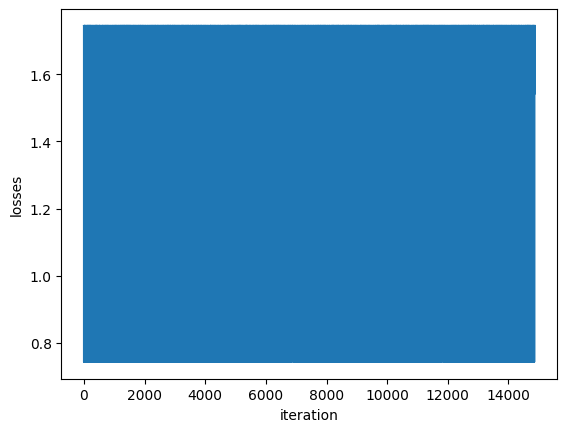

In [ ]:
from matplotlib import pyplot as plt
# plot_train = [loss.detach for loss in train_losses]
plt.plot(train_losses)
plt.xlabel('iteration')
plt.ylabel('losses')